In [1]:
# !poetry run pip install -U git+https://github.com/ichko/aesthetic-tensor

In [122]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML
import mediapy as mpy
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
from aesthetic_tensor import monkey_patch_torch
monkey_patch_torch()

In [124]:
from nca.utils import conv_same

In [125]:
W, H = 128, 64

In [126]:
import cv2

pad = 28
screen = np.zeros((H, W))
cv2.line(screen, [pad, H // 2], [W - pad - 0, H // 2], color=1, thickness=5)

line_screen = torch.tensor(screen, dtype=torch.float32)
line_screen.ae.zoom(2).img

In [127]:
screen = np.zeros((H, W))
pad = 5

cv2.line(screen, [W // 2, 0], [W // 2, H // 2 - pad], color=1, thickness=1)
cv2.line(screen, [W // 2 + 1, 0], [W // 2 + 1, H // 2 - pad], color=1, thickness=1)
cv2.line(screen, [W // 2 - 1, 0], [W // 2 - 1, H // 2 - pad], color=1, thickness=1)

cv2.line(screen, [W // 2, H // 2 + pad], [W // 2, H], color=1, thickness=1)
cv2.line(screen, [W // 2 + 1, H // 2 + pad], [W // 2 + 1, H], color=1, thickness=1)
cv2.line(screen, [W // 2 - 1, H // 2 + pad], [W // 2 - 1, H], color=1, thickness=1)

divider_screen = torch.tensor(screen, dtype=torch.float32)
divider_screen.ae.zoom(2).img

In [128]:
class SimpleNCA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        perc = 3
        hid = 128
        self.chans = 16

        self.seed = nn.Parameter(torch.rand(self.chans, 64, 64) * 2 - 1)
        self.kernel = nn.Sequential(
            nn.Dropout2d(p=0.1),
            conv_same(self.chans, perc * self.chans, ks=5, bias=True, padding_mode="circular"),
            nn.BatchNorm2d(perc * self.chans),
        )
        
        sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])/8
        sobel_y = torch.tensor([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]])/8
        identity = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
        lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

        all_filters = torch.stack((identity, sobel_x, sobel_y))
        all_filters_batch = all_filters.repeat(self.chans, 1, 1).unsqueeze(1)
        self.all_filters_batch = nn.Parameter(all_filters_batch, requires_grad=False)
        
        self.rule = nn.Sequential(
            conv_same(perc * self.chans, hid, ks=1, bias=True),
            nn.ReLU(),
            conv_same(hid, self.chans, ks=1, bias=False),
        )

        nn.init.zeros_(self.rule[-1].weight)

    def forward(self, x, steps=1):
        seq = [x]
        device = next(self.parameters()).device
        x *= 1 - divider_screen.to(device)
        for i in range(steps):
            old_x = x
            x = F.conv2d(
#                 F.pad(x, (1, 1, 1, 1), "circular"),
                F.pad(x, (1, 1, 1, 1), "constant", 0),
                self.all_filters_batch,
                stride=1,
                padding=0,
                groups=self.chans,
            )
            x = self.rule(x)
            x = old_x + x
            x *= 1 - divider_screen.to(device)
            
            seq.append(x)

        seq = torch.stack(seq, axis=1)
        return seq

In [129]:
import torchsummary

In [130]:
nca = SimpleNCA().to("cpu")

In [131]:
inp1 = torch.rand(2, nca.chans, H, W) * 2 - 1
inp2 = torch.zeros(1, nca.chans, H, W)
inp2[0, 0, 32, 32] = 1

inp3 = torch.ones(1, nca.chans, H, W)
inp3[0, 0, 32, 32] = 0

inp = torch.cat([inp1, inp2, inp3])

out = nca(inp, steps=20)
out.ae

float32<4, 21, 16, 64, 128>∈[-1.000, 1.000] | μ=0.244, σ=0.591

In [132]:
torchsummary.summary(nca.to("cuda"), input_size=inp1.size()[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 128, 64, 128]           6,272
              ReLU-2         [-1, 128, 64, 128]               0
            Conv2d-3          [-1, 16, 64, 128]           2,048
Total params: 8,320
Trainable params: 8,320
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.50
Forward/backward pass size (MB): 17.00
Params size (MB): 0.03
Estimated Total Size (MB): 17.53
----------------------------------------------------------------



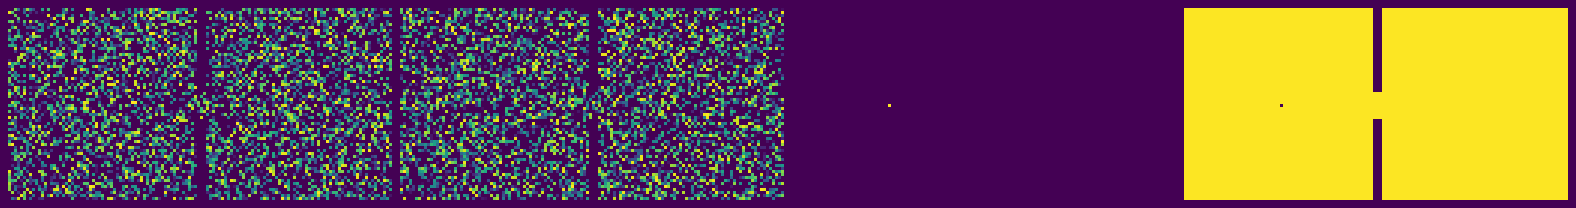

In [133]:
out.ae.zoom(3).grid(ncols=4, pad=4)[:, 0].gif(fps=24)

In [134]:
out.ae

float32<4, 21, 16, 64, 128>∈[-1.000, 1.000] | μ=0.244, σ=0.591

In [135]:
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchdata.datapipes.iter import IterableWrapper

In [136]:
num_classes = 10
ds = MNIST(root="./.data", download=True, transform=ToTensor(), train=True)

In [137]:
bs = 8
dl = DataLoader(IterableWrapper(ds).filter(lambda x: x[1] < num_classes), batch_size=bs, shuffle=True)

/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/graph_settings.py:90: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


In [138]:
batch = next(iter(dl))

In [139]:
np.arange(0, 100, 10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [140]:
def map_input(dl):
    it = iter(dl)
    for x, y in it:
        bs, _, h, w = x.shape
        c = nca.chans
        inp_screen = torch.zeros(bs, c, H, W)
        pad = 30
        inp_screen[
            :, :1,
            H // 2 - h // 2:H // 2 + h // 2,
            pad - w // 2:pad + w // 2,
        ] = x
        outs = []
        for t in np.arange(30, 100, 5):
            pad = t
            
            out_screen = torch.zeros(bs, 1, H, W)
            out_screen[
                :, :1,
                H // 2 - h // 2:H // 2 + h // 2,
                pad - w // 2:pad + w // 2,
            ] = x
            outs.append(out_screen)
        yield {"inp": inp_screen, "out": outs, "cls": y}

In [142]:
gen = map_input(dl)
batch = next(gen)
x, y = batch["inp"], batch["out"]
print(len(y))
y = y[-1]

torch.cat([x[:8, :1], y[:8, :1]]).ae.cmap(dim=2).grid()[0, :3].img

14


In [143]:
nca.to("cpu")(x).ae

float32<8, 2, 16, 64, 128>∈[0.000, 1.000] | μ=0.001, σ=0.025

In [144]:
out.ae

float32<4, 21, 16, 64, 128>∈[-1.000, 1.000] | μ=0.244, σ=0.591

In [145]:
def optim_step(i, nca, batch, optim, device, grad_clip_val=0.1):
    x, ys = batch["inp"], batch["out"]
    x = x.to(device)
    ys = [y.to(device) for y in ys]
    N = len(ys)
    bs = x.shape[0]
    out = nca(x, steps=80)

    loss = 0
    line_target = line_screen.unsqueeze(0).unsqueeze(0).repeat(8, 1, 1, 1).to(device)
    mid_sim_out = out[:, 35:36, 0]

    y = ys[-1]
    loss += F.mse_loss(mid_sim_out, y + line_target)
    target_out = out[:, -25:, :1].mean(axis=[1])
    loss += F.mse_loss(target_out, y)

    if nca.training:
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    return loss, out

In [146]:
from copy import deepcopy

In [147]:
lr = 0.0001
target_nca = deepcopy(nca)
history = []

In [148]:
# with open("save.pkl", "rb") as fp:
#     target_nca = torch.load(fp)

In [149]:
optim = torch.optim.Adam(target_nca.parameters(), lr=lr)

In [150]:
device = "cuda"
target_nca = target_nca.to(device)

In [97]:
target_nca = target_nca.eval()
with torch.no_grad():
    _ = optim_step(0, target_nca, batch, optim, device)

In [98]:
torch.autograd.set_detect_anomaly(True)

In [99]:
save_dir = "checkpoints-ae2"
img_dir = "imgs-ae2"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(img_dir, exist_ok=True)

In [100]:
# !rm -rf {save_dir}
# !rm -rf {img_dir}

Loss: 0.0121972058:  95%|#########4| 75750/80000 [7:55:49<25:30,  2.78it/s]

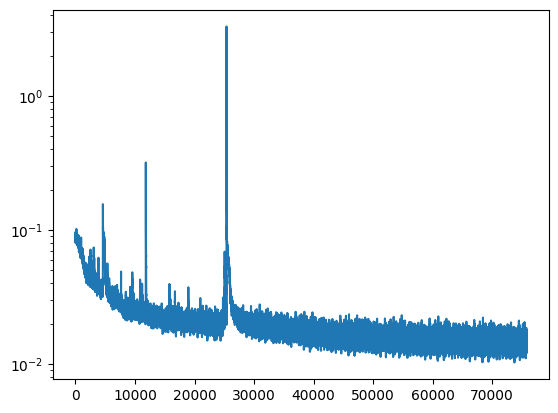

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [101]:
from IPython.display import clear_output

E = len(history)
pbar = tqdm(range(E, E + 80_000))

target_nca = target_nca.train()
for i in pbar:
    try:
        batch = next(gen)
    except StopIteration as err:
        gen = map_input(dl)
        continue

    loss, out = optim_step(i, target_nca, batch, optim, device)
    pbar.set_description(f"Loss: {loss:.10f}")
    history.append(loss.item())

    if i % 250 == 0:
        clear_output(wait=True)
        display(pbar.container)
        plt.plot(history)
        plt.yscale("log")
        plt.show()

        with torch.no_grad():
            t = torch.tensor(out[:8, :, 0].ae.cmap("bwr", dim=2).raw)
            t = t * (255 - 255 * divider_screen[None, None, None])
            gif = t.ae.grid(ncols=4, pad=4)[:, :3].zoom(3).gif(fps=24)
            gif.save(f"{img_dir}/img_{i:06}.gif")

            with open(os.path.join(save_dir, f"model-{i:05}-Lf{loss.item():0.6f}.pkl"), "wb+") as fp:
                torch.save(target_nca, fp)

In [73]:
with torch.no_grad():
    batch = next(gen)
    target_nca = target_nca.eval()
    loss, out = optim_step(0, target_nca, batch, optim, device)

In [74]:
out[:8, :, 0].ae.cmap(dim=2)

uint8<8, 81, 4, 64, 128>∈[1.000, 255.000] | μ=103.083, σ=93.909


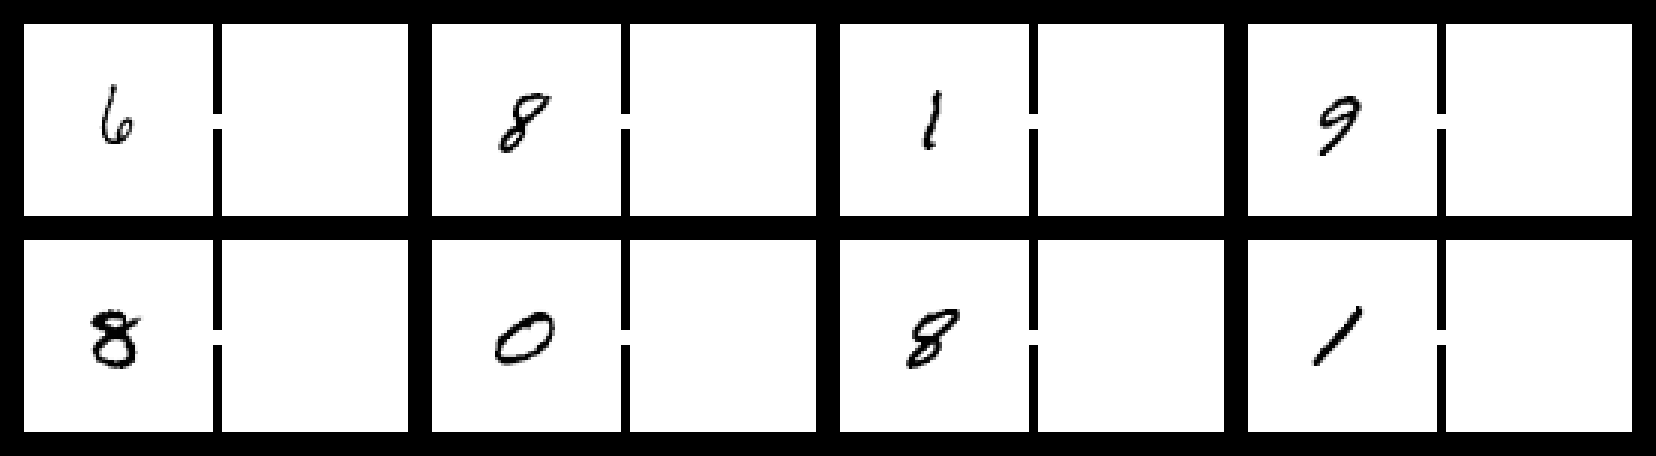

In [75]:
t = torch.tensor(out[:8, :, 0].ae.cmap("Greys", dim=2).raw)
t = t * (255 - 255 * divider_screen[None, None, None])
t.ae.grid(ncols=4, pad=4)[:, :3].zoom(3).gif(fps=24)

In [76]:
# with open("./save.pkl", "wb+") as fp:
#     torch.save(target_nca, fp)

In [77]:
import gc
def clean_mem():
    torch.cuda.empty_cache()
    gc.collect()
    
clean_mem()

In [78]:
# checkpoint_names = os.listdir("./checkpoints2/")
# losses = [float(c.split("Lf")[1].split(".pkl")[0]) for c in checkpoint_names]

# ml = min(losses)
# min_loss_checkpoint_name = [c for c in checkpoint_names if str(ml) in c][0]
# min_loss_nca = torch.load(f"./checkpoints2/{min_loss_checkpoint_name}")

# min_loss_checkpoint_name

In [79]:
# target_nca = min_loss_nca

In [80]:
device = "cuda"

In [81]:
cls_outs = {}
target_nca.eval()
with torch.inference_mode():
    for i in tqdm(range(10)):
        batch = next(gen)
        x = batch["inp"].to("cuda")
        cls = batch["cls"]
        out = target_nca(x, steps=100)
        for c in range(num_classes):
            cls_mask = cls.to("cuda") == c
            if cls_mask.sum() > 0:
                cls_out = out[cls_mask]
                cls_outs.setdefault(c, []).append(cls_out)

  0%|          | 0/10 [00:00<?, ?it/s]

In [82]:
out = []
for i in range(num_classes):
    o = cls_outs[i][0][0, :, :]
    out.append(o)
out = torch.stack(out)

In [86]:
t = torch.tensor(out[:10, :, 0].ae.cmap("bwr", dim=2).raw)
t = t * (255 - 255 * divider_screen[None, None, None])
t.ae.grid(ncols=5, pad=2)[:, :3].zoom(3).gif(fps=24)

In [84]:
t = torch.tensor(out[:10, :, :16].ae.cmap("bwr", dim=2).raw)
t = t * (255 - 255 * divider_screen[None, None, None, None])

In [87]:
t.permute(0, 3, 1, 2, 4, 5).ae.grid(ncols=1, pad=1).grid(ncols=8, pad=1)[:, :3].zoom(1).gif(fps=20)

In [ ]:
num_outs = []
for cls in range(num_classes):
    max_val = -1
    max_id = -1
    max_out = None
    for outs, t in cls_outs[cls]:
        if outs.shape[0] == 0:
            continue
        vals = -((outs[:, -1, 0] - t) ** 2).mean([1, 2])
        argmax = vals.argmax()
        if vals[argmax] > max_val:
            max_val = vals[argmax]
            max_id = argmax
            max_out = outs[argmax]

    num_outs.append(max_out)

num_outs = torch.stack(num_outs)
num_outs.ae

In [ ]:
num_outs[0:10, [0, 10, 20, 30, 40, 50, -30], 0].ae.cmap("viridis", dim=-3)\
    .grid(ncols=10, pad=0).grid(ncols=1, pad=0)[:3].img

In [ ]:
num_outs[1, [0, 10, 20, 30, 40, 50, -30]][:, [0,3,4,11,13,15]].ae.grid(ncols=7).grid(ncols=1).zoom(1).img

In [ ]:
torch.cat([
    num_outs[:, :1].repeat((1, 20, 1, 1, 1)),
    num_outs,
], dim=1).ae.zoom(3).grid(ncols=10, pad=2)[:, 0]

In [ ]:
vid = torch.cat([
    num_outs[:, :1].repeat((1, 20, 1, 1, 1)),
    num_outs,
], dim=1).ae.zoom(1).grid(ncols=3, pad=2)

In [ ]:
vid.raw.shape

In [ ]:
# mpy.show_video(vid.raw[:, :3], fps=60, border=True)

In [ ]:
paused = torch.cat([
    num_outs[:, :1].repeat((1, 40, 1, 1, 1)),
    num_outs,
#     num_outs[:, -1:].repeat((1, 20, 1, 1, 1)),
], dim=1)

In [ ]:
paused.ae

In [ ]:
hid_vid = paused.permute(0, 2, 1, 3, 4)[:,[0,1,3,8,9,10,11,12,13,14]].ae \
    .grid(ncols=1).grid(ncols=10).zoom(1).cmap("viridis")[:, :, :, :3]

In [ ]:
hid_vid

In [ ]:
# mpy.show_video(hid_vid.raw, fps=60, border=True)

In [ ]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan',
]

In [ ]:
def plot_fun(out, frame_id=-1, batch_id=0):
    f = frame_id
    b = batch_id
    out = out.detach().cpu()
    bs, L, _, H, W = out.shape
    im = out[b, f, 0]

    vals_list = []
    for cls in range(num_classes):
        vals = out[b, :f, 0][:, screen == cls + 1].mean(axis=-1)
        vals_list.append(vals)

    bar_vals_list = []
    for cls in range(num_classes):
        bar_vals = out[b, f, 0][screen == cls + 1].mean(axis=-1)
        bar_vals_list.append(bar_vals)
    bar_vals = torch.stack(bar_vals_list)

    fig, axs = plt.subplots(4, 1, figsize=(2, 8), dpi=100)
    axs[0].imshow(out[b, 0, 0], interpolation='none', aspect="auto", cmap="Greys_r")
    axs[1].imshow(out[b, frame_id, 0], interpolation='none', aspect="auto", cmap="Greys_r")

    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
#     axs[1].set_xticks([])
    axs[3].set_xticks([])
    axs[1].set_yticks([])
    axs[2].set_yticks([])
    axs[3].set_yticks([])

    for cls in range(num_classes):
        c = colors[cls]
        axs[1].contour(screen == cls + 1, colors=c, linewidths=3, alpha=0.9)
        axs[2].plot(vals_list[cls], c=c)
        axs[3].bar(range(num_classes), bar_vals, color=colors[:num_classes])

    axs[0].set_aspect(1)
    axs[1].set_aspect(1)
    axs[2].axhline(1, color="tab:grey", linestyle="--", linewidth=0.5)
    axs[2].axhline(0, color="tab:grey", linestyle="--", linewidth=0.5)
    axs[2].set_xlim(0, L)
    axs[2].set_ylim(-0.1, 1.1)

    axs[3].set_ylim(0, 1)
    axs[3].set_xticks(range(num_classes))

    plt.tight_layout(pad=1)

    plt.close()
    return fig

plot_fun(paused, -1, 0)

In [ ]:
L = paused.shape[1]
figs_list = []
for cls in tqdm(range(num_classes)):
    figs = [plot_fun(paused, i, cls) for i in tqdm(range(0, L))]
    figs_list.append(figs)

In [ ]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches="tight", pad_inches=0.1)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [ ]:
pils_list = []
for figs in tqdm(figs_list):
    pils = [fig2img(f) for f in tqdm(figs)]
    pils_list.append(pils)

In [ ]:
# pils_list[0][-1]

In [ ]:
cat_pils = [
    Image.fromarray(
        np.concatenate([
            np.concatenate([np.array(ps[frame_id]) for ps in pils_list[:10]  ], axis=1),
#             np.concatenate([np.array(ps[frame_id]) for ps in pils_list[5:10]], axis=1)
        ], axis=0)
    ) for frame_id in tqdm(range(len(pils_list[0])))
]

In [ ]:
cat_pils[-1]

In [ ]:
import numpy as np

image_stack = np.ones((2, 2, 18))

extra_left, extra_right = 1, 2
extra_top, extra_bottom = 3, 1

np.pad(image_stack, ((extra_top, extra_bottom), (extra_left, extra_right), (0, 0)),
       mode='constant', constant_values=3).shape

In [ ]:
def rescale_pil(pil, scale=1):
    W, H = pil.size
    new_W, new_H = int(W * scale), int(H * scale)
    return pil.resize((new_W, new_H))

In [ ]:
rescale_pil(cat_pils[0], scale=0.9).size

In [ ]:
def gif_from_pils(pils, fps):
    pils = [rescale_pil(p, scale=0.9) for p in pils]
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [ ]:
len(cat_pils)

In [ ]:
gif_from_pils(cat_pils[10:], fps=30)